In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [5]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=outliers_features_to_skip,
                                           is_convert_angles_to_category=True)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_column_name="smiles",
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25


In [6]:
best_hyperparams = rf_train.find_best_params_with_hyperopt()


100%|██████████| 500/500 [14:33<00:00,  1.75s/trial, best loss: 0.09870110872490326]
Найкращі гіперпараметри: {'max_depth': 10, 'max_features': 16, 'min_samples_leaf': 0, 'min_samples_split': 5, 'n_estimators': 1968}


In [7]:
from hyperopt import space_eval
best_hyperparams = space_eval(rf_train.space, best_hyperparams)

model = rf_train.train(max_depth=best_hyperparams['max_depth'], 
                       max_features=best_hyperparams['max_features'], 
                       min_samples_leaf=best_hyperparams['min_samples_leaf'], 
                       min_samples_split=best_hyperparams['min_samples_split'], 
                       n_estimators=best_hyperparams['n_estimators'])

model_cv = rf_train.train(max_depth=best_hyperparams['max_depth'], 
                       max_features=best_hyperparams['max_features'], 
                       min_samples_leaf=best_hyperparams['min_samples_leaf'], 
                       min_samples_split=best_hyperparams['min_samples_split'], 
                       n_estimators=best_hyperparams['n_estimators'])

Mean Squared Error: 0.05090995700125344
Mean Squared Error: 0.05090995700125344


SAVE RF AS JOBLIB

In [8]:
import joblib

save_path_for_rf = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\random_forest\models\07.05.24_features_v5\logP\logP_rf_all_molecules.joblib'

joblib.dump(model, save_path_for_rf)

['C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\random_forest\\models\\07.05.24_features_v5\\logP\\logP_rf_all_molecules.joblib']

TRAIN:

In [9]:
y_train = rf_train.y_train
X_train = rf_train.X_train
y_pred = model.predict(X_train.drop(['fold_id'], axis=1))

calculate_metrics(y_train, y_pred)

{'mse': 0.02, 'mae': 0.104, 'r_score': 0.937}

Cross-val

In [11]:
RFTrain.calculate_crossval_metrics(model_cv, rf_train.X_train, rf_train.y_train)

{'mse_oos': 0.099,
 'mae_oos': 0.239,
 'r^2_oos': 0.6915,
 'mse_train': 0.027,
 'mae_train': 0.1245,
 'r^2_train': 0.915}

OOS:

In [12]:
y_test = rf_train.y_test
X_test = rf_train.X_test
y_pred = model.predict(X_test)

calculate_metrics(y_test, y_pred)

{'mse': 0.051, 'mae': 0.196, 'r_score': 0.809}

Tree importance

Text(0.5, 0, 'Random Forest Feature(tree) Importance')

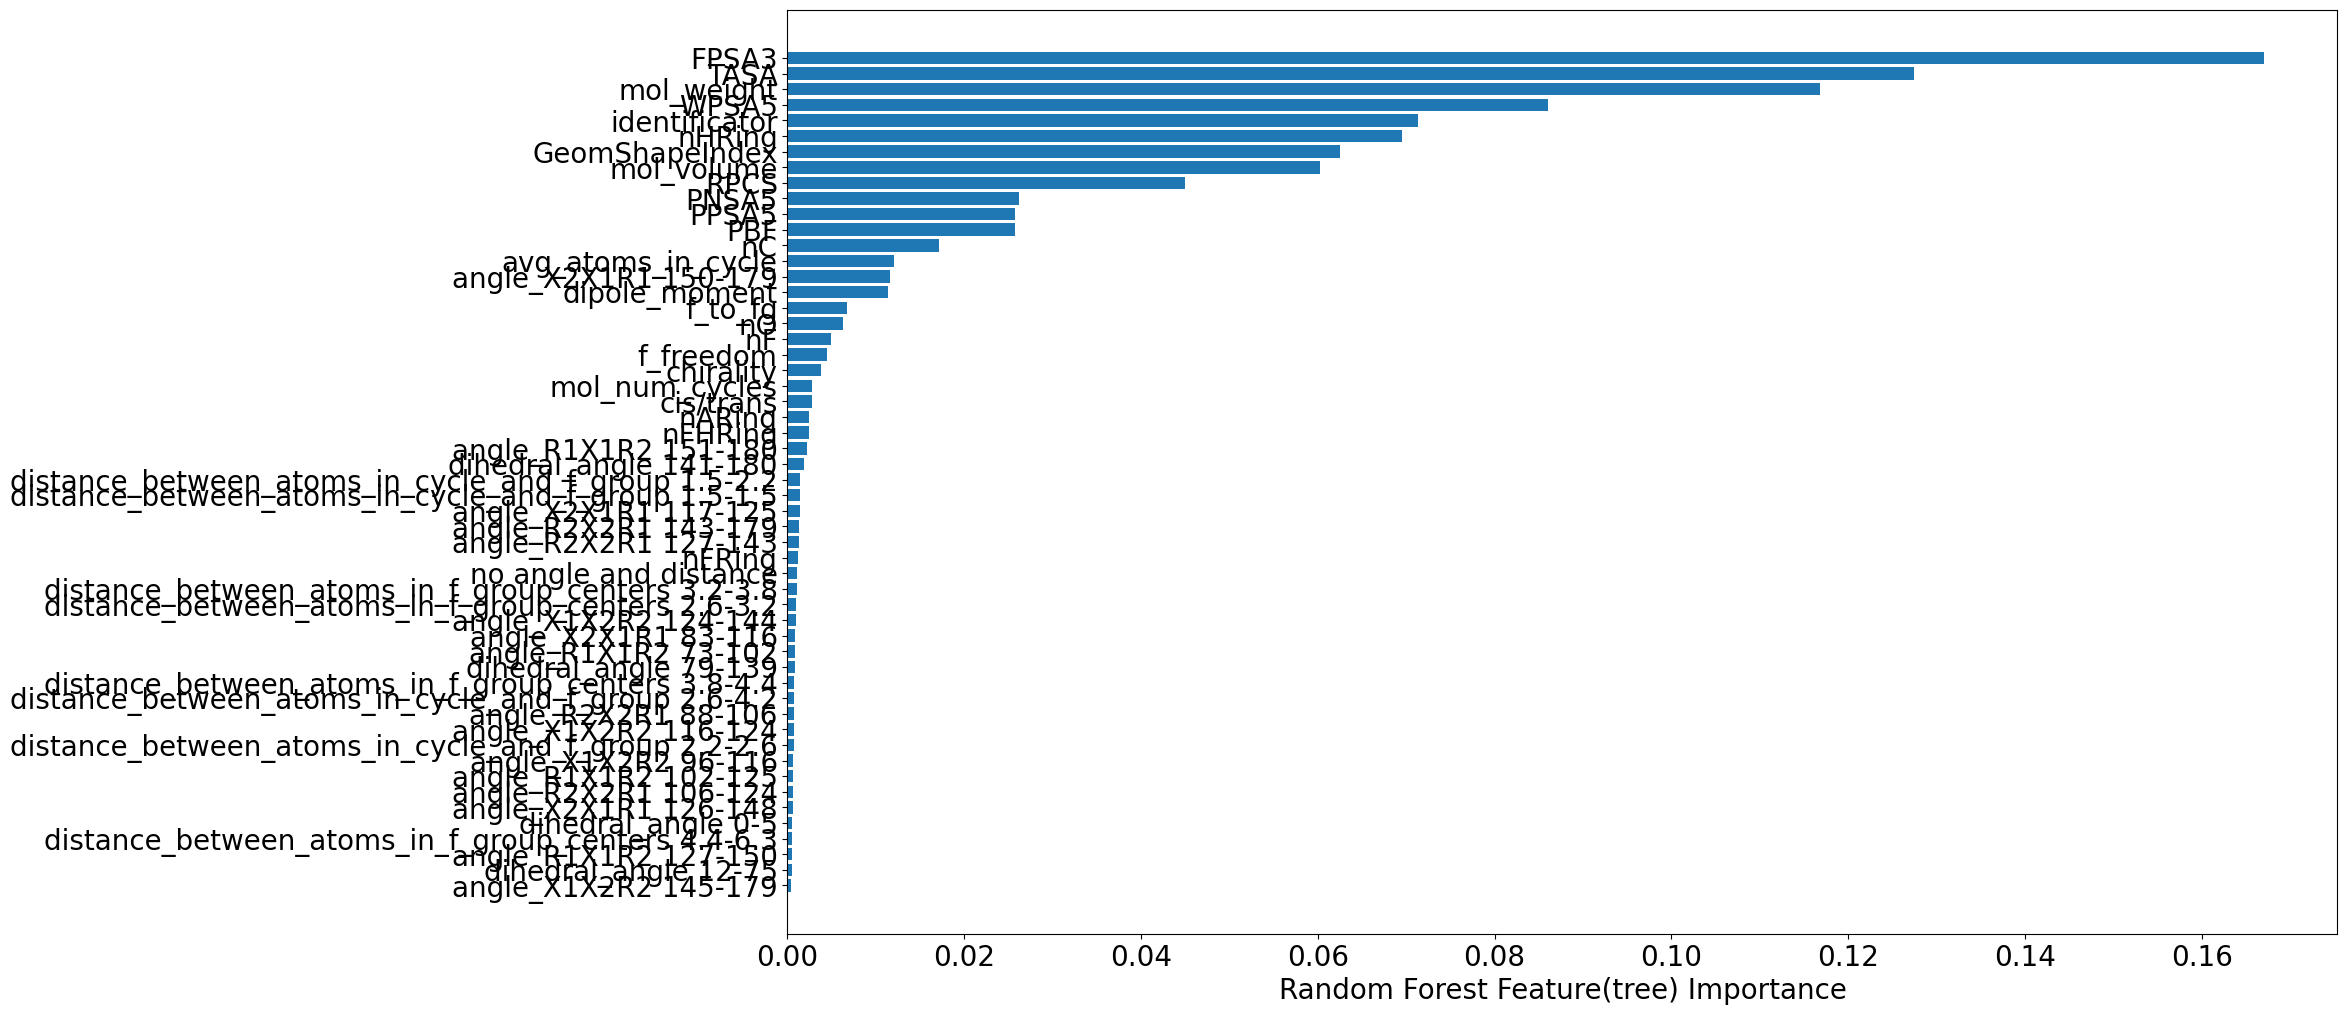

In [13]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(20,12))
plt.barh(X.columns[sorted_idx][::-1][:][::-1], model.feature_importances_[sorted_idx][::-1][:][::-1])
plt.xlabel("Random Forest Feature(tree) Importance")

Permutation score

Text(0.5, 0, 'Permutation Importance')

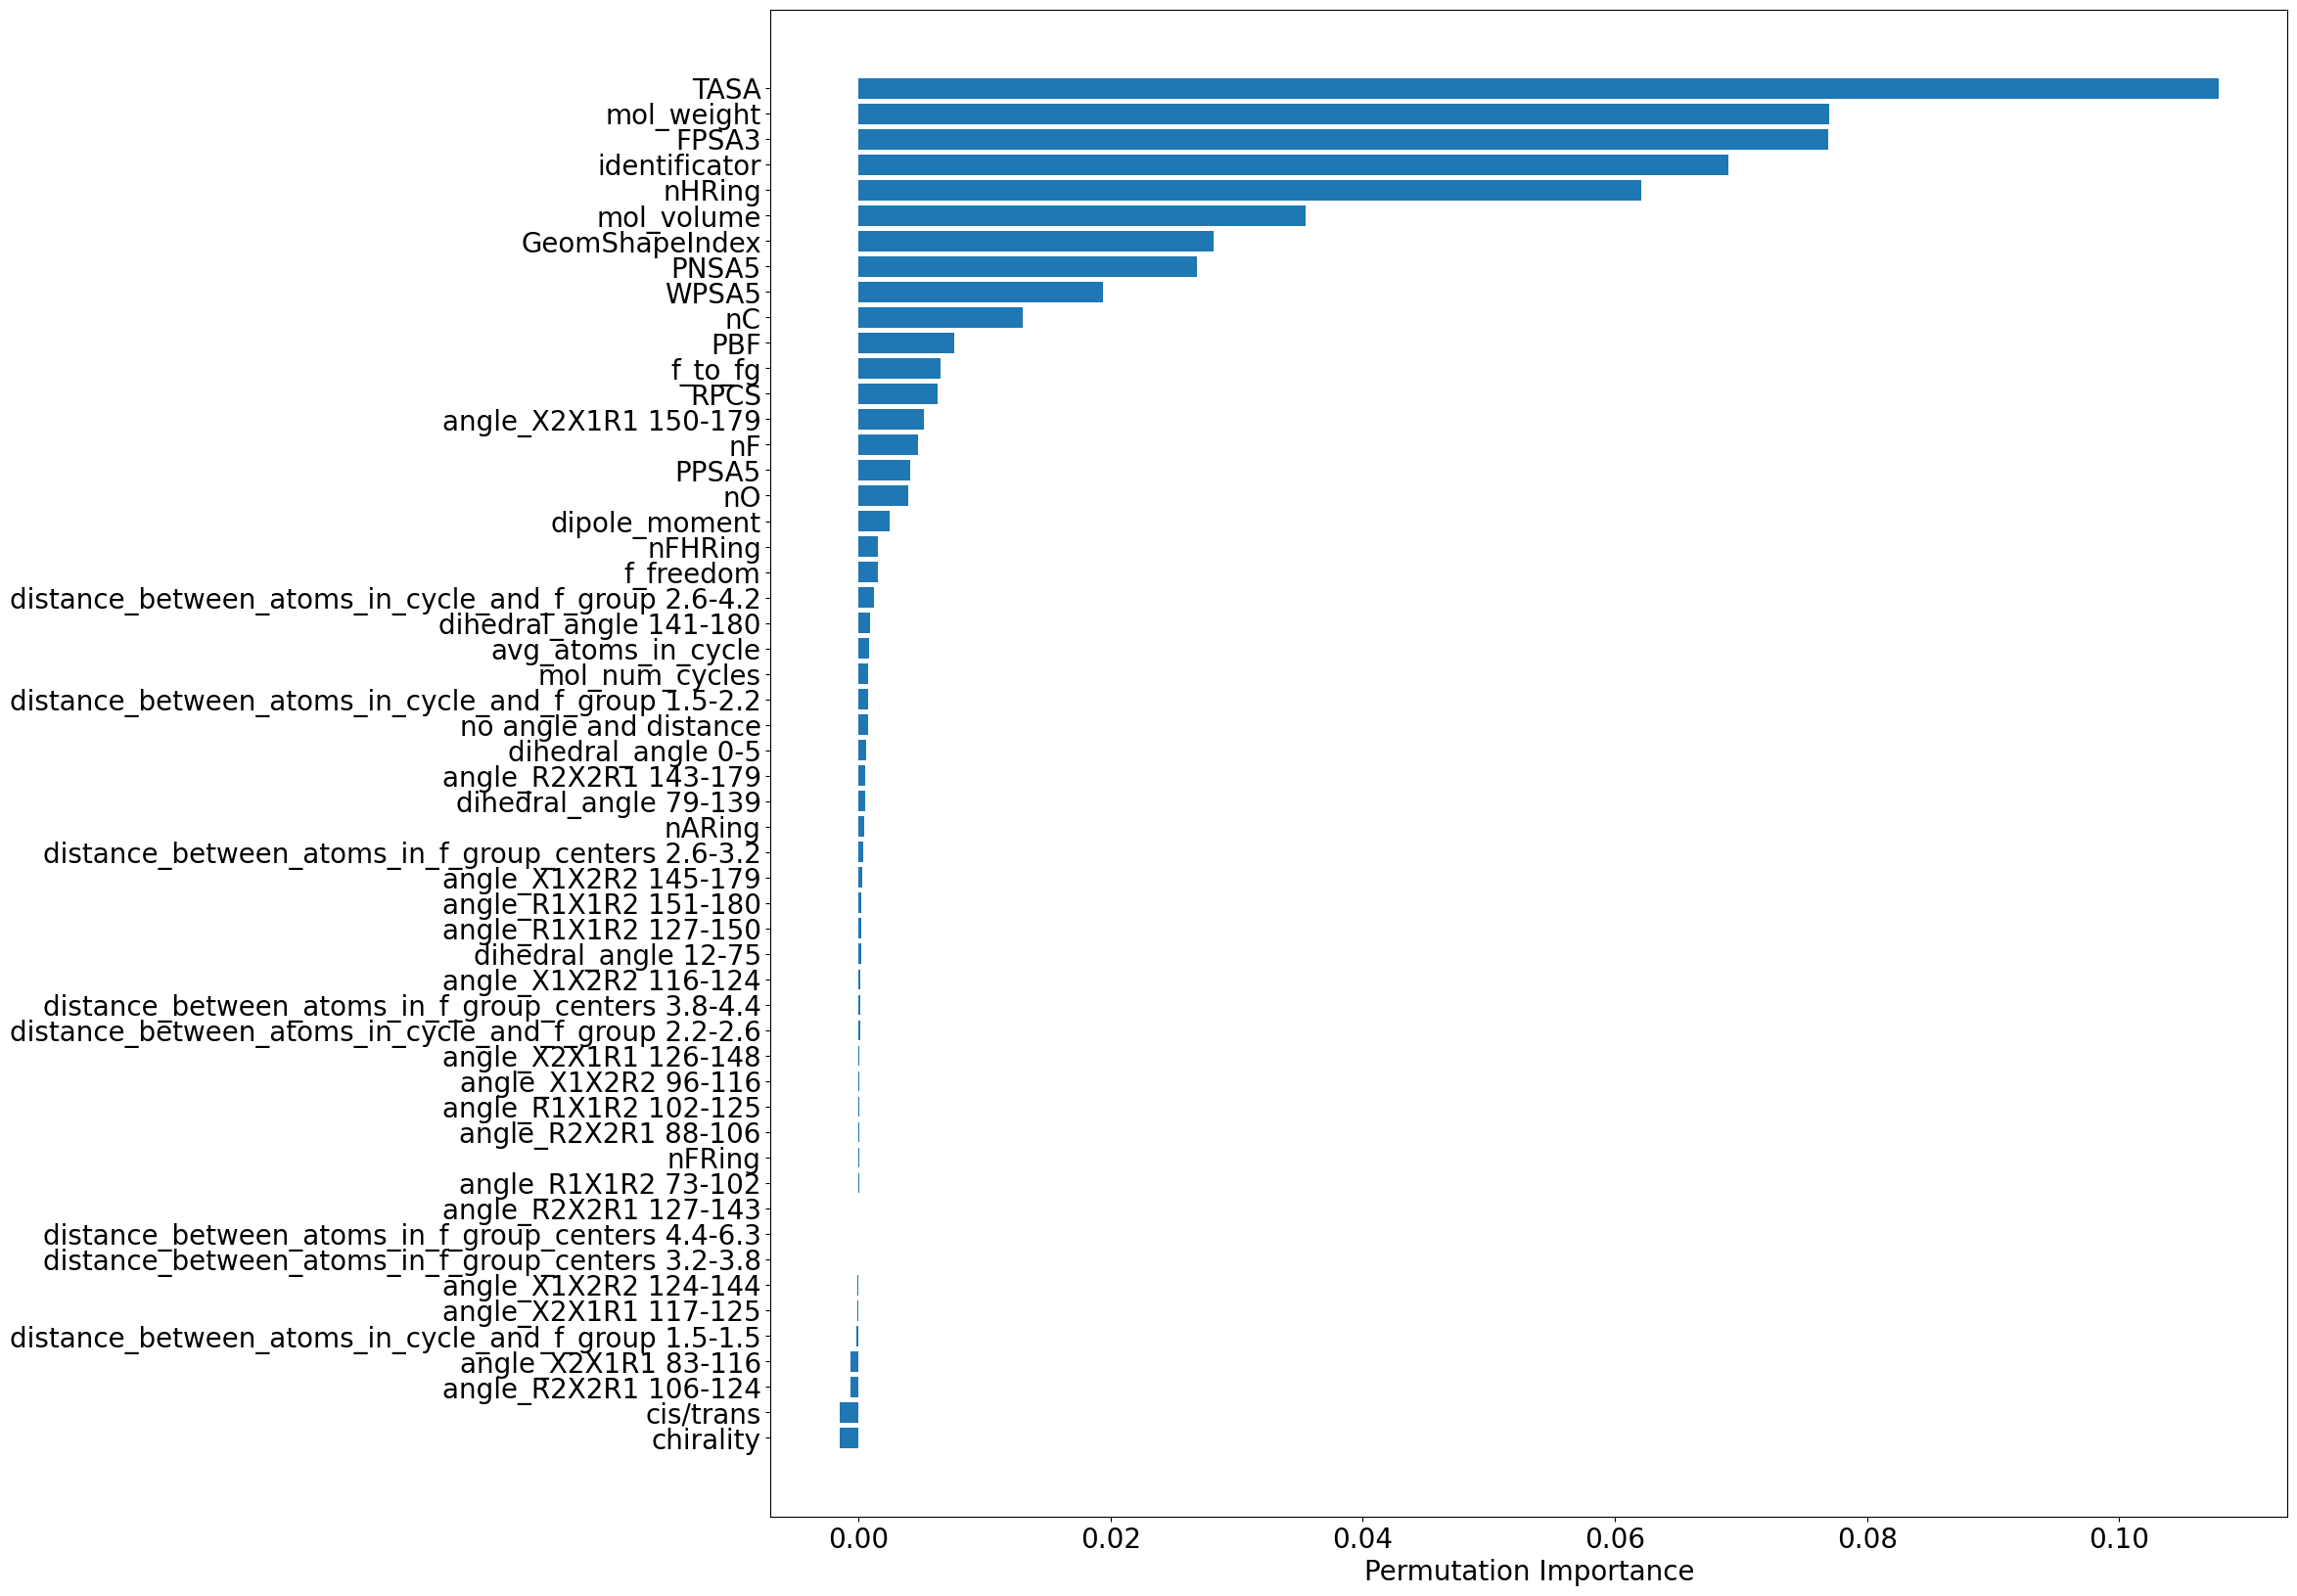

In [14]:
# fine tuned for more than hour
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=50)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(20,20))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

**SHAP**

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


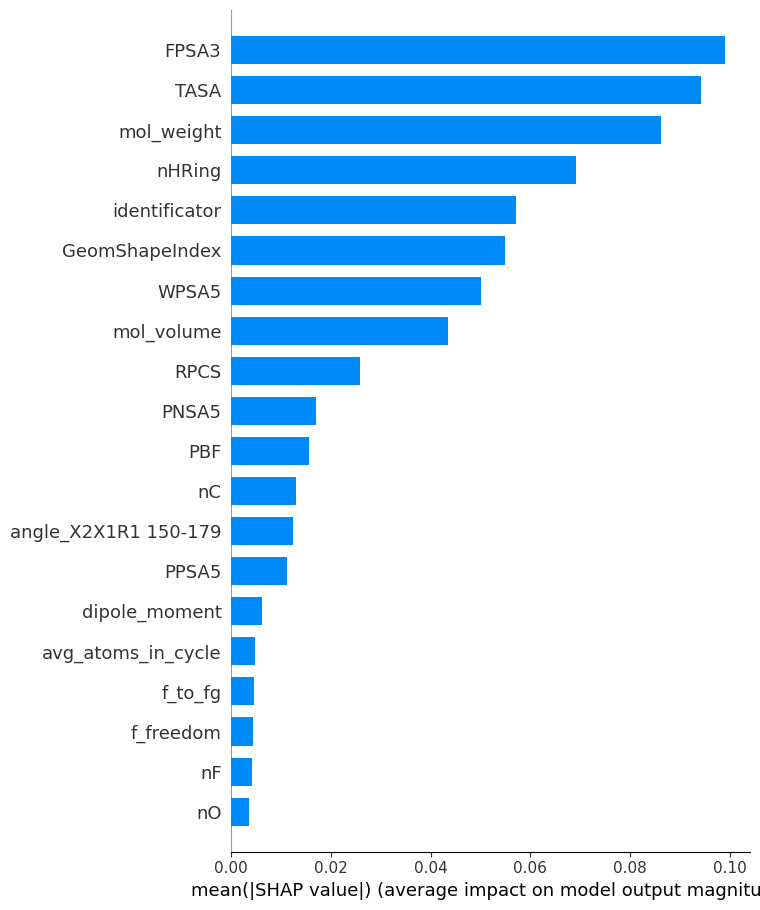

In [15]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


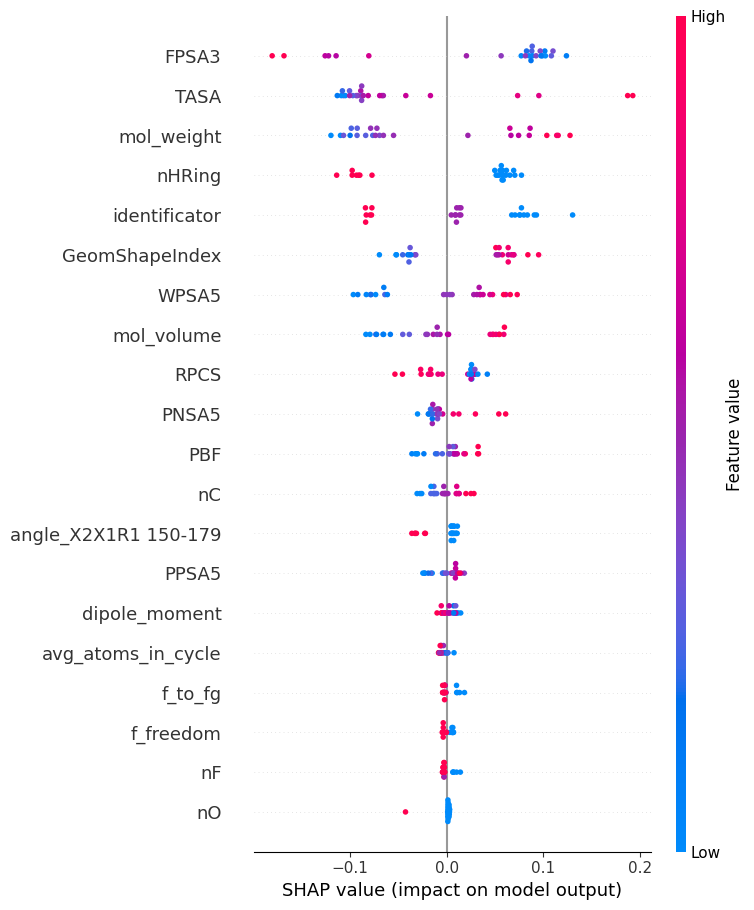

In [16]:
shap.summary_plot(shap_values, X_test)